## Logistic Regression

### Preparing data
对每个属性做正则化，处理后将其切分为训练集和开发集

In [21]:
import numpy as np

np.random.seed(0)
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
  next(f)
  X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
  next(f)
  Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
  next(f)
  X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
  # This function normalizes specific columns of X.
  # The mean and standard variance of training data will be reused when processing testing data.
  #
  # Arguments:
  #     X: data to be processed
  #     train: 'True' when processing training data, 'False' for testing data
  #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
  #         will be normalized.
  #     X_mean: mean value of training data, used when train = 'False'
  #     X_std: standard deviation of training data, used when train = 'False'
  # Outputs:
  #     X: normalized data
  #     X_mean: computed mean value of training data
  #     X_std: computed standard deviation of training data

  if specified_column == None:
      specified_column = np.arange(X.shape[1])
  if train:
      X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
      X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

  X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
    
  return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
  # This function spilts data into training set and development set.
  train_size = int(len(X) * (1 - dev_ratio))
  return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


### some useful functions
这几个函数可能会在训练中被重复用到

In [22]:
def shuffle(X, Y):
  # this function shuffles two equal-length list together
  randomize = np.arange(len(X))
  np.random.shuffle(randomize)
  return (X[randomize], Y[randomize])

def sigmoid(z):
  # sigmoid function can be used to calculate probability
  # to avoid overflow, minimun/maximum output value is set
  return np.clip(1 / (1 + np.exp(-z)), 1e-8, 1 - (1e-8))

def hypothese(X, w, b):
  # This is the logistic regression function, parameterized by w and b
  # Arguements:
  #   X: input data, shape = [batch_size, data_dimension]
  #   w: weight vector, shape = [data_dimension, ]
  #   b: bias, scalar
  # Output:
  #   predicted probability of each row of X being positively labeled, shape = [batch_size, ]
  return sigmoid(np.matmul(X, w) + b)

def predict(X, w, b):
  # this function returns a truth value prediction for each row of X
  # by rounding the result of logistic regression function
  return np.round(hypothese(X, w, b)).astype(int)

def accuracy(Y_pred, Y_label):
  acc = 1 - np.mean(np.abs(Y_pred - Y_label))
  return acc

### functions about gradient descent
梯度和损失函数的计算

In [23]:
def cross_entropy_loss(y_pred, Y_label):
  # this function computes the cross entropy
  # Arguements:
  #   y_pred: probabilistic predictions, float vector
  #   Y_label: ground truth labels, bool vector
  # Output:
  #   cross entropy, scalar
  cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
  return cross_entropy

def gradient(X, Y_label, w, b):
  # computes the gradient of cross entrop loss with respect to weight w and bias b
  y_pred = hypothese(X, w, b)
  pred_error = Y_label - y_pred
  w_grad = -np.sum(pred_error * X.T, 1)
  b_grad = -np.sum(pred_error)
  return w_grad, b_grad

### training
使用小批次梯度下降法来训练。训练集被分为许多小批次，针对每个小批次，我们分别计算其梯度和损失，并根据改批次来更新模型的参数。当一次迭代完成，也就是整个训练集的所有小批次都被使用过一次后，我们将所有训练集打散并重新分成新的小批次，进行下一次迭代，直到迭代全部完成

In [24]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 10
batch_size = 8
learning_rate = 0.2

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
  # Random shuffle at the begging of each epoch
  X_train, Y_train = shuffle(X_train, Y_train)
      
  # Mini-batch training
  for idx in range(int(np.floor(train_size / batch_size))):
    X = X_train[idx*batch_size:(idx+1)*batch_size]
    Y = Y_train[idx*batch_size:(idx+1)*batch_size]

    # Compute the gradient
    w_grad, b_grad = gradient(X, Y, w, b)
        
    # gradient descent update
    # learning rate decay with time
    w = w - learning_rate/np.sqrt(step) * w_grad
    b = b - learning_rate/np.sqrt(step) * b_grad

    step = step + 1
  
  # Compute loss and accuracy of training set and development set
  y_train_pred = hypothese(X_train, w, b)
  Y_train_pred = np.round(y_train_pred)
  train_acc.append(accuracy(Y_train_pred, Y_train))
  train_loss.append(cross_entropy_loss(y_train_pred, Y_train) / train_size)

  y_dev_pred = hypothese(X_dev, w, b)
  Y_dev_pred = np.round(y_dev_pred)
  dev_acc.append(accuracy(Y_dev_pred, Y_dev))
  dev_loss.append(cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.271355435246406
Development loss: 0.2896359675026286
Training accuracy: 0.8836166291214418
Development accuracy: 0.8733873940287504


### plotting loss and accuracy curve

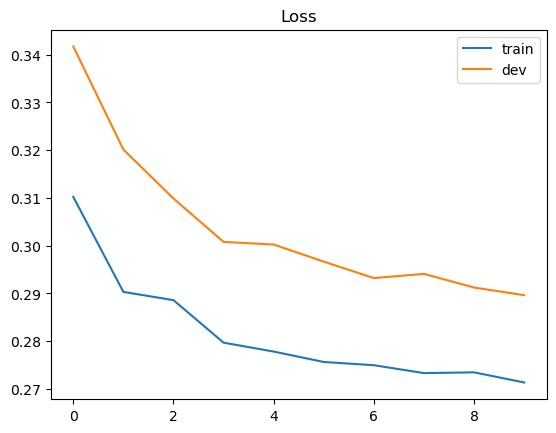

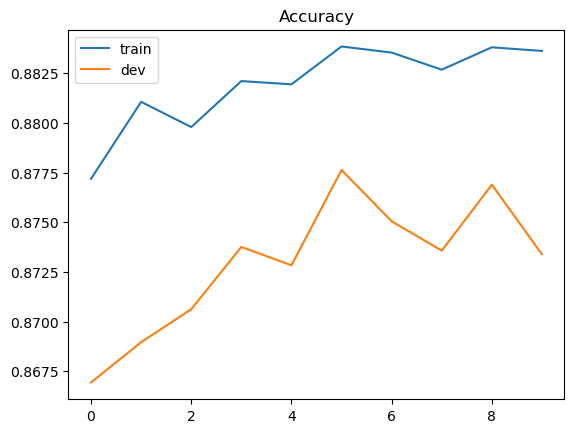

In [25]:
import matplotlib.pyplot as plt

# loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.show()

# accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.show()

### predicting testing labels
预测测试集的数据标签并存储在output_logistic.csv中

In [27]:
# predict testing labels
predictions = predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
  f.write('id,label\n')
  for i, label in enumerate(predictions):
    f.write(f'{i},{label}\n')

# print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
  content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
  print(features[i], w[i])

 Not in universe -4.031960278019252
 Spouse of householder -1.6254039587051394
 Other Rel <18 never married RP of subfamily -1.41957597757654
 Child 18+ ever marr Not in a subfamily -1.2958572076664725
 Unemployed full-time 1.1712558285885908
 Other Rel <18 ever marr RP of subfamily -1.1677918072962366
 Italy -1.0934581438006181
 Vietnam -1.0630365633146415
num persons worked for employer 0.9389922773566495
 1 0.8226614922117184
